In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


Load fashion mnist dataset.

In the following you will learn:
- How to load the dataset (train & test set)
- How to display some data
- How to build a pytorch Dataset
- How to build a Dataloader

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

You can also apply some transformations when you load the data

https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html


In [ ]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Display the images with matplotlib or pyplot with their label

In the following cell you have the label map

In [4]:
# labels_map = {
#     0: "T-Shirt",
#     1: "Trouser",
#     2: "Pullover",
#     3: "Dress",
#     4: "Coat",
#     5: "Sandal",
#     6: "Shirt",
#     7: "Sneaker",
#     8: "Bag",
#     9: "Ankle Boot",
# }

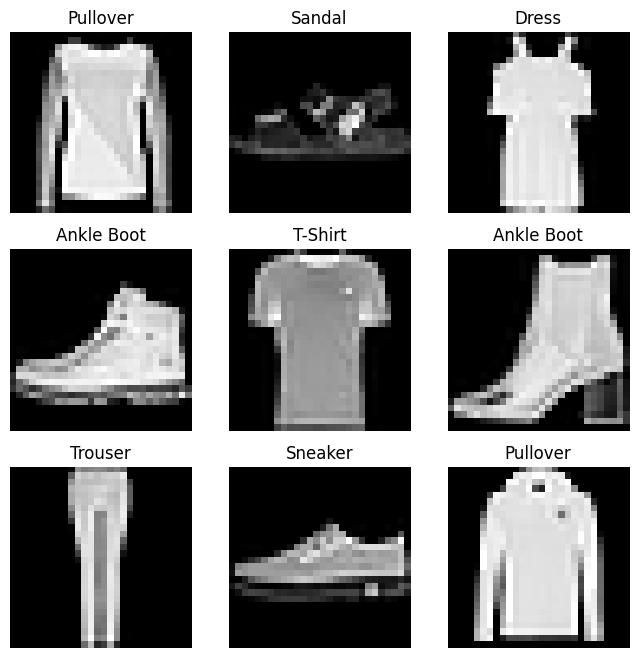

In [5]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
test_data[0][0].shape, test_data[0][1]

(torch.Size([1, 28, 28]), 9)

Build the data loader

`from torch.utils.data import DataLoader`

Apply some transformations:

- Flatten the last 3 dimensions

Currently, we have

shape = (batch_size, nb_channels, img_width, img_height)

we want a 2D matrix

shape = (batch_size, nb_channels * img_width * img_height)

For this you can create a dataset wrapper

You can also play with the batch_size witch is an important parameter

In [7]:
from torch.utils.data import DataLoader

In [8]:
class FlattenTransform:
    def __call__(self, x):
        return x[0].flatten(), x[1]

class DatasetWrapper(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        if self.transform:
            data = self.transform(data)

        return data

In [9]:
flatten_transform = FlattenTransform()

In [10]:
train_data_flatten = DatasetWrapper(train_data, transform=flatten_transform)
test_data_flatten = DatasetWrapper(test_data, transform=flatten_transform)

In [11]:
train_dataloader = DataLoader(train_data_flatten, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data_flatten, batch_size=64, shuffle=False)

In [12]:
for x, y in train_dataloader:
    print(x.min())
    print(x.mean())
    print(x.max())
    print(x.shape)
    print(y)
    break

tensor(0.)
tensor(0.2936)
tensor(1.)
torch.Size([64, 784])
tensor([5, 8, 0, 2, 0, 0, 0, 9, 4, 1, 1, 5, 5, 1, 3, 9, 7, 9, 9, 0, 9, 6, 3, 2,
        0, 0, 6, 1, 8, 1, 0, 7, 5, 1, 6, 1, 4, 5, 3, 8, 1, 3, 3, 2, 3, 3, 2, 6,
        8, 6, 4, 9, 8, 4, 0, 5, 5, 5, 8, 4, 8, 6, 5, 8])


In [13]:
from torch import nn

You can follow this link for a simple neural net implementation

https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

You don't have to use nn.Sequential you can directly define all the layers directly as attribute of the class.

[OPT] Now test to apply Conv1 on your model

-> It should not work, it is not appropriate for the flatten of an image

Try 2D Conv, you can check this link

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-convolutional-neural-network

In [41]:
class SimpleNeuralNetwork(nn.Module):
    def __init__(self, input_size: int, nb_class: int):
        super().__init__()
        self.hidden_size = 512
        self.first_layer = nn.Linear(in_features=input_size, out_features=self.hidden_size)
        self.last_layer = nn.Linear(in_features=self.hidden_size, out_features=nb_class)
        self.relu_fn = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # shape = [batch_size, input_size]
        # shape = [batch_size, nb input features]
        x_out = self.first_layer(x)

        # shape = [batch_size, self.hidden_size]
        x_out = self.relu_fn(x_out)

        # shape = [batch_size, self.hidden_size]
        logits = self.last_layer(x_out)

        # shape = [batch_size, nb_class]
        return logits

class NeuralNetworkSkipConn(nn.Module):
    def __init__(self, input_size: int, nb_class: int):
        super().__init__()
        self.first_layer = nn.Linear(in_features=input_size, out_features=input_size)
        self.last_layer = nn.Linear(in_features=input_size, out_features=nb_class)
        self.relu_fn = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # shape = [batch_size, input_size]
        # shape = [batch_size, nb input features]
        x_out = self.first_layer(x)

        # Residual conn
        x_out += x

        # shape = [batch_size, self.hidden_size]
        x_out = self.relu_fn(x_out)

        # shape = [batch_size, self.hidden_size]
        logits = self.last_layer(x_out)

        # shape = [batch_size, nb_class]
        return logits

class CNNNetwork(nn.Module):
    def __init__(self, nb_class: int):
        super().__init__()
        self.reshape = nn.Unflatten(1, (1, 28, 28))  # Reshape flat input to [1, 28, 28]
        self.first_conv = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.second_conv = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.linear = nn.Linear(64 * 7 * 7, 300)
        self.linear2 = nn.Linear(300, 10)
        self.relu_fn = nn.ReLU()
        self.max_pool_fn = nn.MaxPool2d(2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # shape = [batch_size, input_size]
        x_out = self.reshape(x)

        # shape = [batch_size, 1, 28, 28]
        x_out = self.relu_fn(self.first_conv(x_out))

        # shape = [batch_size, 32, 28, 28]
        x_out = self.max_pool_fn(x_out)

        # shape = [batch_size, 32, 14, 14]
        x_out = self.relu_fn(self.second_conv(x_out))

        # shape = [batch_size, 64, 14, 14]
        x_out = self.max_pool_fn(x_out)

        # shape = [batch_size, 64, 7, 7]
        x_out = torch.flatten(x_out, 1)

        # shape = [batch_size, 3136]
        x_out = self.linear(x_out)

        x_out = self.relu_fn(x_out)
        x_out = self.linear2(x_out)

        # shape = [batch_size, 10]
        return x_out

In [42]:
# TEST
tmp_net = NeuralNetworkSkipConn(4, 3)

tmp_inpt = torch.rand((10, 4))
tmp_output = tmp_net(tmp_inpt)
tmp_output.shape

torch.Size([10, 3])

In [43]:
# TEST
tmp_net = CNNNetwork(4)

tmp_inpt = torch.rand((10, 784))
tmp_output = tmp_net(tmp_inpt)
tmp_output.shape

torch.Size([10, 10])

In [93]:
# nn_model = NeuralNetworkSkipConn(input_size=784, nb_class=len(labels_map))
# nn_model

nn_model = CNNNetwork(nb_class=10)
nn_model

CNNNetwork(
  (reshape): Unflatten(dim=1, unflattened_size=(1, 28, 28))
  (first_conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (second_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear): Linear(in_features=3136, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=10, bias=True)
  (relu_fn): ReLU()
  (max_pool_fn): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [94]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [95]:
count_parameters(nn_model)

962926

Build the optimizer

https://pytorch.org/docs/stable/optim.html

Start with SGD

Compare different optimizer

- SGD
- SGD with nesterov
- Adagrad
- Adam
- NAdam
- RAdam

For each optimizer you test, you need to explain a bit how it works

Test at least 3 optimizer

Also play with the parameters of the optimizer (for instance the learning rate)

Try to put a big learning rate and a small learning rate

In [96]:
from torch.optim import SGD, Adam

In [97]:
for elm in nn_model.parameters():
    print(elm.shape)

torch.Size([32, 1, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([300, 3136])
torch.Size([300])
torch.Size([10, 300])
torch.Size([10])


In [98]:
optimizer = SGD(nn_model.parameters(), lr=0.007, momentum=0.8)
optimizer

# optimizer = Adam(nn_model.parameters(), lr=0.007)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.007
    maximize: False
    momentum: 0.8
    nesterov: False
    weight_decay: 0
)

Build the loss function

https://pytorch.org/docs/stable/nn.html#loss-functions

Test different loss function

Choose the right loss for our model knowing labels are integers

[OPT] Test another loss function

In [99]:
loss_fn = loss = nn.CrossEntropyLoss()
loss_fn

CrossEntropyLoss()

Build the training loop and validation loop functions

https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop

Keep the information of the prediction to compute the metrics

You can use tqdm for the progress bar

In [100]:
nn_model = nn_model.to(device)

In [101]:
from tqdm import tqdm

In [102]:
def train_epoch(train_dataloader, nn_model, loss_fn, optimizer):
    nn_model.train()
    loss_l = []
    running_loss = 0.

    for i, data in tqdm(enumerate(train_dataloader)):
        inputs, labels = data

        # Send the tensor on GPU if GPU is available
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the gradient
        optimizer.zero_grad()

        # Make the prediction of the model
        outputs = nn_model(inputs)

        # Compute the loss and the gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust the weights / parameters
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

        loss_l.append(loss.item())

    return torch.tensor(loss_l)


def valid_epoch(test_dataloader, nn_model, loss_fn):
    nn_model.eval()

    loss_l, predictions, labels_l = [], [], []
    softmax_fn = nn.Softmax(dim=1)


    with torch.no_grad():
        for i, data in enumerate(test_dataloader):
            inputs, labels = data

            # Send the tensor on GPU if GPU is available
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Make the prediction of the model
            outputs = nn_model(inputs)

            predictions.append(softmax_fn(outputs).detach().cpu())
            labels_l.append(labels.detach().cpu())


            loss = loss_fn(outputs, labels)
            loss_l.append(loss.item())

    return torch.tensor(loss_l), torch.vstack(predictions), torch.hstack(labels_l)


def train_and_valid_model(nb_epochs, train_dataloader, test_dataloader, nn_model, loss_fn, optimizer):
    train_loss, test_loss = [], []
    for i in range(nb_epochs):
        loss_train_epoch = train_epoch(train_dataloader, nn_model, loss_fn, optimizer)
        loss_test_epoch, _, _ = valid_epoch(test_dataloader, nn_model, loss_fn)

        print(f"EPOCH {i}")
        print(f"Train loss: {loss_train_epoch.mean()}")
        print(f"Test loss: {loss_test_epoch.mean()}")
        print()

        train_loss.append(loss_train_epoch.mean())
        test_loss.append(loss_test_epoch.mean())

    return torch.tensor(train_loss), torch.tensor(test_loss)

In [103]:
train_loss, test_loss = train_and_valid_model(12, train_dataloader, test_dataloader, nn_model, loss_fn, optimizer)

938it [00:09, 103.63it/s]


EPOCH 0
Train loss: 0.7809353470802307
Test loss: 0.5543866753578186



938it [00:09, 102.76it/s]


EPOCH 1
Train loss: 0.4601638913154602
Test loss: 0.4241493344306946



938it [00:09, 103.95it/s]


EPOCH 2
Train loss: 0.3855965733528137
Test loss: 0.3988005518913269



938it [00:09, 103.96it/s]


EPOCH 3
Train loss: 0.3477824926376343
Test loss: 0.3710425794124603



938it [00:09, 103.12it/s]


EPOCH 4
Train loss: 0.3185156285762787
Test loss: 0.3604371249675751



938it [00:09, 104.13it/s]


EPOCH 5
Train loss: 0.2966580390930176
Test loss: 0.327574223279953



938it [00:09, 103.83it/s]


EPOCH 6
Train loss: 0.28132450580596924
Test loss: 0.29952865839004517



938it [00:09, 103.99it/s]


EPOCH 7
Train loss: 0.26704156398773193
Test loss: 0.2992006540298462



938it [00:09, 102.44it/s]


EPOCH 8
Train loss: 0.252716064453125
Test loss: 0.29622170329093933



938it [00:09, 103.77it/s]


EPOCH 9
Train loss: 0.24113871157169342
Test loss: 0.28270453214645386



938it [00:09, 103.47it/s]


EPOCH 10
Train loss: 0.23213140666484833
Test loss: 0.26994943618774414



938it [00:09, 102.54it/s]


EPOCH 11
Train loss: 0.22148728370666504
Test loss: 0.2596273124217987



Plot the training and test loss of your model

You can find many examples on the web with matplotlib or plotly

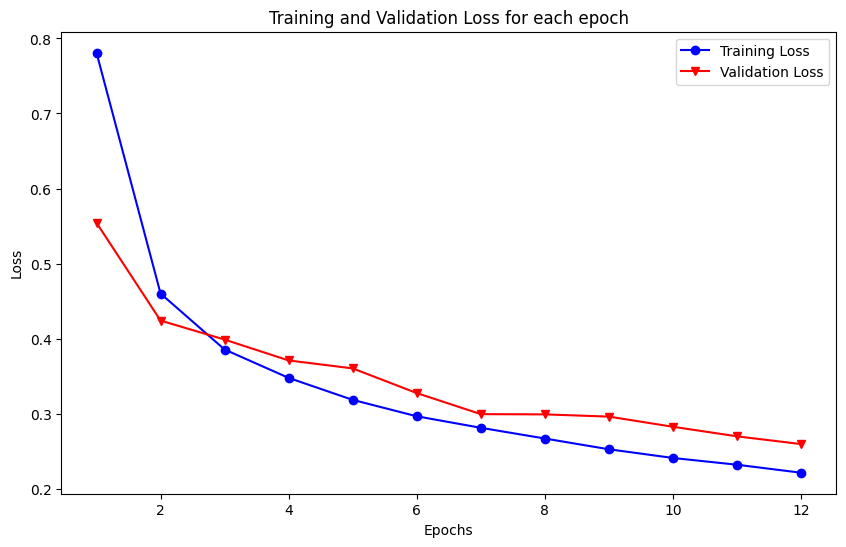

In [104]:
# Create a range object for the x-axis (number of epochs)
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, color='blue', marker='o', label='Training Loss')
plt.plot(epochs, test_loss, color='red', marker='v', label='Validation Loss')

# Add title and labels to the plot
plt.title('Training and Validation Loss for each epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

Now apply your model on both dataloader (train & test) and compute the metrics (you can use sklearn metrics if you want)

We want to have a look at:

- Accuracy
- Precision (check what is 'micro' and 'macro')
- Recall (check what is 'micro' and 'macro')
- f1 score (check what is 'micro' and 'macro')

Don't forget to take the argmax of your predictions to have the classes of your model and not the probabilities

In [105]:
_, train_predictions, train_labels = valid_epoch(train_dataloader, nn_model, loss_fn)
_, test_predictions, test_labels = valid_epoch(test_dataloader, nn_model, loss_fn)

In [106]:
train_predictions.shape, test_predictions.shape

(torch.Size([60000, 10]), torch.Size([10000, 10]))

In [107]:
train_labels.shape, test_labels.shape

(torch.Size([60000]), torch.Size([10000]))

In [108]:
test_predictions

tensor([[7.7549e-06, 1.0354e-06, 1.1300e-05,  ..., 2.1877e-02, 5.9344e-04,
         9.7449e-01],
        [7.9014e-05, 3.0334e-10, 9.9912e-01,  ..., 2.0021e-10, 1.9578e-08,
         2.6011e-10],
        [5.3251e-07, 1.0000e+00, 5.5136e-09,  ..., 7.3178e-11, 3.9986e-09,
         9.9350e-12],
        ...,
        [4.0825e-05, 5.3356e-09, 4.4123e-05,  ..., 1.2773e-06, 9.9920e-01,
         2.2703e-09],
        [6.3391e-06, 9.9936e-01, 1.5620e-07,  ..., 7.2836e-08, 2.8823e-07,
         1.7213e-08],
        [6.2615e-04, 7.7011e-05, 3.1373e-03,  ..., 1.0616e-01, 3.6165e-02,
         1.6245e-04]])

In [109]:
train_prediction_classes = train_predictions.argmax(axis=1)
test_prediction_classes = test_predictions.argmax(axis=1)
test_prediction_classes

tensor([9, 2, 1,  ..., 8, 1, 5])

In [110]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [111]:
def display_metrics(preds, labels):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')

    print(f"Acc: {accuracy}")
    print(f"Precision (macro): {precision}")
    print(f"Recall (macro): {recall}")
    print(f"f1score (macro): {f1}")

In [112]:
display_metrics(train_prediction_classes, train_labels)

Acc: 0.9254166666666667
Precision (macro): 0.9260751171802403
Recall (macro): 0.9254166666666667
f1score (macro): 0.9255746953870515


In [113]:
display_metrics(test_prediction_classes, test_labels)

Acc: 0.9062
Precision (macro): 0.9067735142941071
Recall (macro): 0.9061999999999999
f1score (macro): 0.9063039970178581
